In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
from skopt import BayesSearchCV

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression

In [3]:
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
RANDOM_STATE=177013

In [5]:
df = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/train.csv', index_col=['row_id'], parse_dates=['date'])

## Overview

In [6]:
df.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.2+ MB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_sold,70128.0,194.296986,126.893874,19.0,95.0,148.0,283.0,986.0


In [9]:
df.isna().mean()

date        0.0
country     0.0
store       0.0
product     0.0
num_sold    0.0
dtype: float64

In [10]:
df['country'].value_counts()

Belgium    11688
France     11688
Germany    11688
Italy      11688
Poland     11688
Spain      11688
Name: country, dtype: int64

In [11]:
df['store'].value_counts()

KaggleMart    35064
KaggleRama    35064
Name: store, dtype: int64

In [12]:
df['product'].value_counts()

Kaggle Advanced Techniques          17532
Kaggle Getting Started              17532
Kaggle Recipe Book                  17532
Kaggle for Kids: One Smart Goose    17532
Name: product, dtype: int64

In [13]:
def visualize(df, columns, xlim=(0)):
    for c in columns:
        column = df[c]
        xlabel = column.name
        fig, axes = plt.subplots(1, 2, figsize=(16,7))

        sns.histplot (column, ax=axes[0], bins='fd', kde=False)
        axes[0].set (title='Histogram', xlabel=xlabel, ylabel='Observations', xlim=xlim);
        sns.violinplot (data=column, ax=axes[1], x=column, orient='h')
        axes[1].set (title='Range and density estimation', xlabel=xlabel, xlim=xlim);

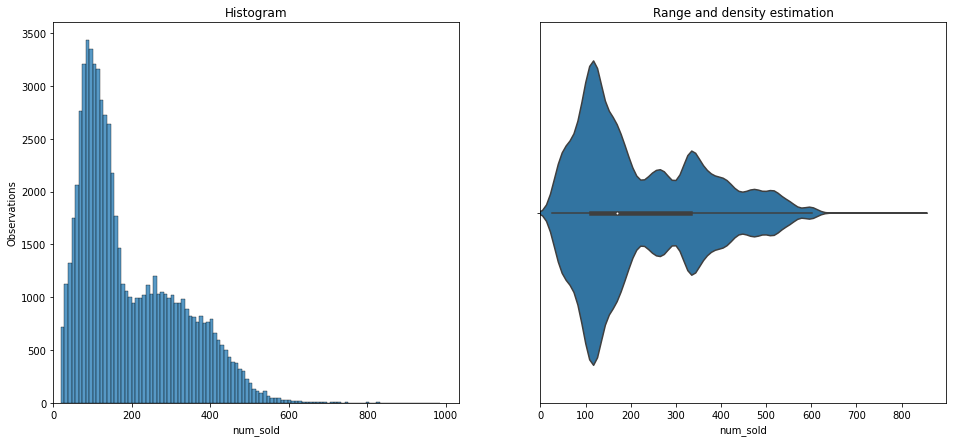

In [14]:
visualize(df, ['num_sold'])

### First thoughts

Pretty nice, well balanced, no missing data. Dates, three categories and an integer target. If only we could smoothly continue the time series as opposed to having a discrete test set with no targets! But... perhaps we can work it around yet?

## EDA

### Peak sales

In [15]:
df.sort_values(by='num_sold', ascending=False).head(90)

,date,country,store,product,num_sold
row_id,,,,,
34963,2018-12-30,Germany,KaggleMart,Kaggle for Kids: One Smart Goose,986
52435,2019-12-29,Germany,KaggleMart,Kaggle for Kids: One Smart Goose,959
34915,2018-12-29,Germany,KaggleMart,Kaggle for Kids: One Smart Goose,931
34947,2018-12-30,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,925
17443,2017-12-30,Germany,KaggleMart,Kaggle for Kids: One Smart Goose,909
...,...,...,...,...,...
17441,2017-12-30,Germany,KaggleMart,Kaggle Getting Started,657
17387,2017-12-29,France,KaggleMart,Kaggle for Kids: One Smart Goose,656
69979,2020-12-28,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,655


New Year holidays seem to attract most customers. A good model should learn this fact. **We should provide it with a day of year data, at the very least.**

### Stores

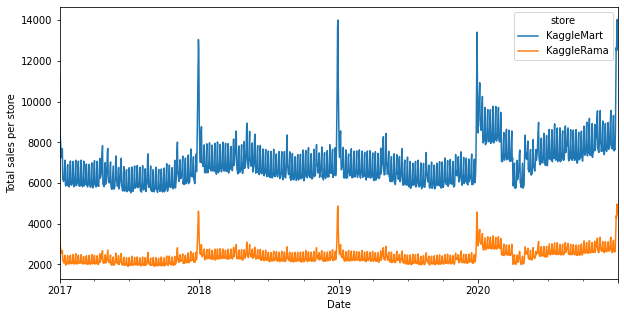

In [16]:
df.pivot_table(index='date', columns='store', values='num_sold', aggfunc='sum').plot(figsize=(10,5)).set(xlabel='Date', ylabel='Total sales per store');

mean      0.346787
median    0.346789
Name: ratio, dtype: float64

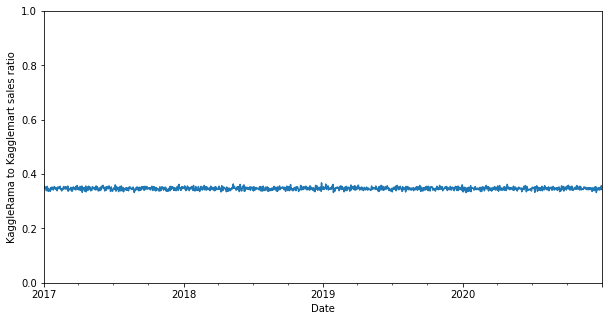

In [17]:
store_pivot = df.pivot_table(index='date', columns='store', values='num_sold', aggfunc='sum')
store_pivot['ratio'] = store_pivot['KaggleRama'] / store_pivot['KaggleMart']
store_pivot['ratio'].plot(figsize=(10,5)).set(ylim=(0,1), xlabel='Date', ylabel='KaggleRama to Kagglemart sales ratio')
store_pivot['ratio'].agg(['mean','median'])

Two stores sales ratio is basically constant a bit below 0.35 with no significant outliers.

### Products

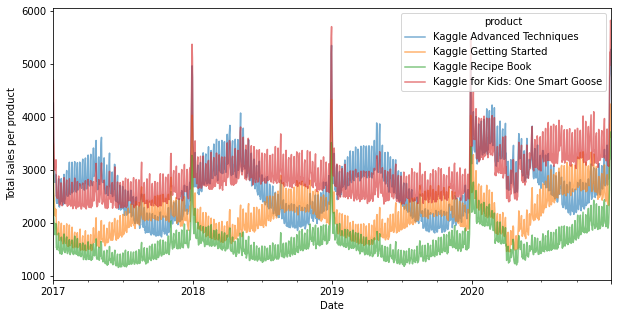

In [18]:
df.pivot_table(index='date', columns='product', values='num_sold', aggfunc='sum').plot(figsize=(10,5), alpha=0.6).set(xlabel='Date', ylabel='Total sales per product');

The beginning of 2020 distorts it a bit, yet seasonality clearly shows.

### Countries

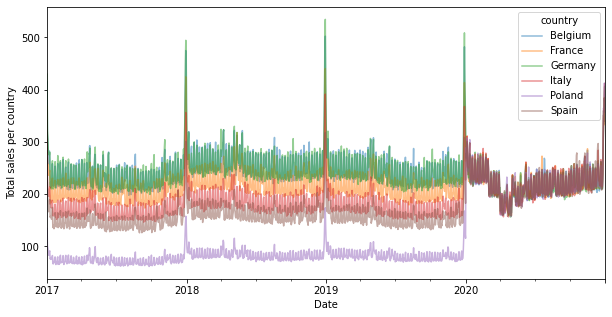

In [19]:
df.pivot_table(index='date', columns='country', values='num_sold', aggfunc='mean').plot(alpha=0.5, figsize=(10,5)).set(xlabel='Date', ylabel='Total sales per country');

A methodological change? Apart from Germany and Belgium, pre-2020 sales ratios are clearly different. **That means pre-2020 data for those countries is not helpful as is, but what if we augment it?**

country,Belgium,France,Italy,Poland,Spain
mean,0.998571,0.872606,0.726553,0.324969,0.635845
median,0.997312,0.869048,0.724258,0.324287,0.634080
min,0.836735,0.740794,0.624481,0.275415,0.542028
max,1.189843,1.039397,0.873007,0.395719,0.772878


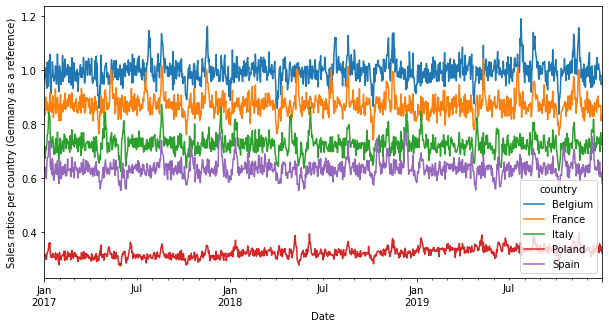

In [20]:
country_pivot = df.query('date < "2020-01-01"').pivot_table(index='date', columns='country', values='num_sold', aggfunc='sum')
country_pivot['Belgium'] = country_pivot['Belgium'] / country_pivot['Germany']
country_pivot['France'] = country_pivot['France'] / country_pivot['Germany']
country_pivot['Italy'] = country_pivot['Italy'] / country_pivot['Germany']
country_pivot['Poland'] = country_pivot['Poland'] / country_pivot['Germany']
country_pivot['Spain'] = country_pivot['Spain'] / country_pivot['Germany']
country_pivot.drop('Germany', axis=1).plot(figsize=(10,5)).set(xlabel='Date', ylabel='Sales ratios per country (Germany as a reference)')
country_pivot.drop('Germany', axis=1).agg(['mean','median', 'min', 'max'])

Apart from Poland, which had sales growing (albeit very slightly), pre-2020 ratios seem constant on average. **We can bring sales to the same scale and use for training:**

In [21]:
country_coefs = {
    'France' : 0.87,
    'Italy' : 0.725,
    'Poland' : 0.3245,
    'Spain' : 0.635,
    'Belgium' : 1,
    'Germany' : 1,
}

def boost_old_sales(row):
    if row['date'] < pd.to_datetime("2020-01-01"):
        return round(float(row['num_sold']) / country_coefs[row['country']])
    else:
        return row['num_sold']

### Seasonality

In [22]:
total_pivot = df.pivot_table(index=['date'], values='num_sold', aggfunc='sum').reset_index()

In [23]:
total_pivot['day'] = total_pivot['date'].dt.dayofyear
total_pivot['dow'] = total_pivot['date'].dt.dayofweek

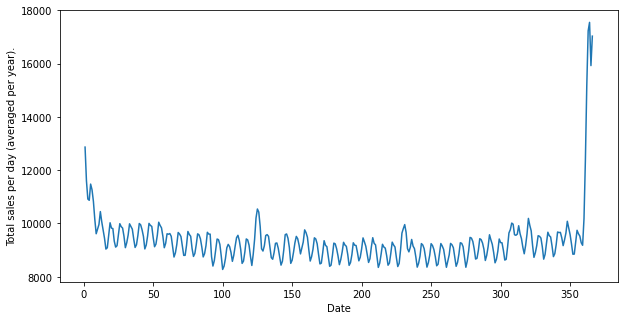

In [24]:
(total_pivot.drop(['date'], axis=1).groupby(['day'])['num_sold'].mean()).plot(figsize=(10,5)).set(xlabel='Date', ylabel='Total sales per day (averaged per year).');

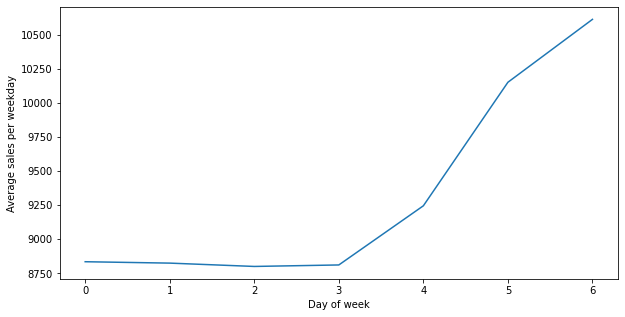

In [25]:
(total_pivot.drop(['date'], axis=1).groupby(['dow'])['num_sold'].mean()).plot(figsize=(10,5)).set(xlabel='Day of week', ylabel='Average sales per weekday');

There's an apparent weekly cycle, thus **we'll need a day of a week as well**.

In [26]:
day_store_sold = df.groupby(['date', 'store', 'country'])['num_sold'].transform('sum')
day_product_sold = df.groupby(['date', 'store', 'product', 'country'])['num_sold'].transform('sum')
df['ratio'] = day_product_sold / day_store_sold

In [27]:
ratio_pivot = df.pivot_table(index=['date'], columns='product', values='ratio', aggfunc='mean').reset_index()

In [28]:
ratio_pivot

product,date,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
0,2017-01-01,0.279035,0.225867,0.187638,0.307460
1,2017-01-02,0.279226,0.225286,0.182709,0.312780
2,2017-01-03,0.291791,0.222552,0.186694,0.298963
3,2017-01-04,0.285842,0.223164,0.192205,0.298788
4,2017-01-05,0.282845,0.227849,0.184805,0.304501
...,...,...,...,...,...
1456,2020-12-27,0.279626,0.228384,0.186892,0.305098
1457,2020-12-28,0.285201,0.219228,0.189535,0.306036
1458,2020-12-29,0.277224,0.227098,0.188946,0.306733
1459,2020-12-30,0.281063,0.223349,0.195373,0.300215


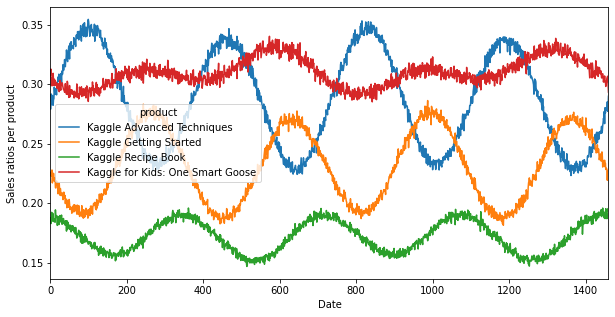

In [29]:
ratio_pivot.drop(['date'], axis=1).plot(figsize=(10,5)).set(xlim=(0,1460), xlabel='Date', ylabel='Sales ratios per product');

Looking close, the product sales ratio cycle is biannual. **Now, let's try to smooth it and make a trading indicator!**

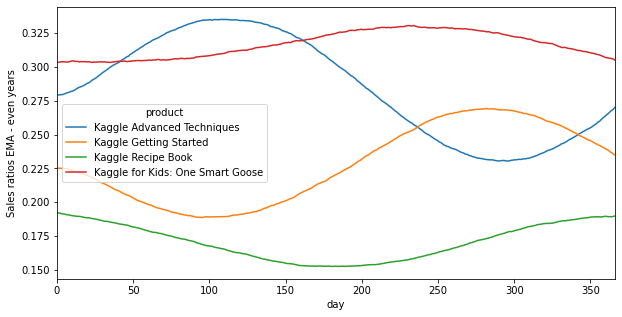

In [30]:
rp1 = ratio_pivot.loc[(ratio_pivot['date'].dt.year % 2) == False]
rp1['day'] = rp1['date'].dt.dayofyear
ind1 = rp1.drop(['date'], axis=1).groupby('day').mean().ewm(span=30, min_periods=0, adjust=False, ignore_na=False).mean()
ind1.plot(figsize=(10,5)).set(xlim=(0,366), ylabel='Sales ratios EMA - even years');

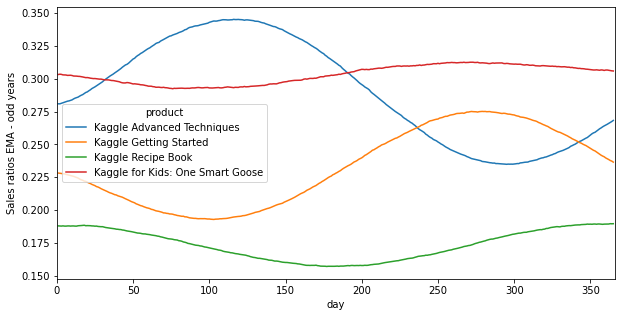

In [31]:
rp2 = ratio_pivot.loc[(ratio_pivot['date'].dt.year % 2) == True]
rp2['day'] = rp2['date'].dt.dayofyear
ind2 = rp2.drop(['date'], axis=1).groupby('day').mean().ewm(span=30, min_periods=0, adjust=False, ignore_na=False).mean()
ind2.plot(figsize=(10,5)).set(xlim=(0,366), ylabel='Sales ratios EMA - odd years');

## Preprocessing

We'll perform the following steps:

- add date-based features (day of a year, day of a week);
- add product ratio EMA value, do not include any other product info;
- 'encode' store category into a constant ratio;
- scale up pre-2020 country sales.

What **did not** work:

- national holidays;
- basic periodical features;
- elapsed year (overfits badly).

In [32]:
def add_indicator(row):
    table = ind1 if (row['date'].year % 2) == False else ind2
    return table.loc[row['day']][row['product']]

In [33]:
def is_ny(row):
    return ((row['date'].day in range(28, 32) and row['date'].month == 12) or
              (row['date'].day == 1 and row['date'].month == 1))

In [34]:
def create_date_features(df):
    result = df.copy()
    result['ny'] = result.apply(is_ny, axis=1).astype('int')
    result['dayofweek'] = result['date'].dt.dayofweek
    result['day'] = result['date'].dt.dayofyear
    result['indicator'] = result.apply(add_indicator, axis=1)
    return result

def bin_to_ratio(df, columns, ratio):
    for column in columns:
        df[column] = 1 + df[column] * (ratio - 1)
    return df

def sales_boost(df):
    df['num_sold'] = df.apply(boost_old_sales, axis=1)
    return df

def one_hot_encoding(df, columns):
    dummies = pd.get_dummies(df[columns], drop_first=True)
    df[dummies.columns] = dummies
    return df

def name_cleanup(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

def drop_unused_columns (df, column_list):
    return df.drop (column_list, axis=1)

In [35]:
encoded_columns = ['store']

In [36]:
unused_columns = encoded_columns + ['date', 'country', 'product']

In [37]:
data = (
        df.pipe(create_date_features)
        .pipe(sales_boost)
        .pipe(one_hot_encoding, encoded_columns)
        .pipe(drop_unused_columns, unused_columns + ['ratio'])
        .pipe(name_cleanup)
        .pipe(bin_to_ratio, ['store_kagglerama'], 0.34679)
    )

In [38]:
data

,num_sold,ny,dayofweek,day,indicator,store_kagglerama
row_id,,,,,,
0,663,1,6,1,0.280869,1.00000
1,615,1,6,1,0.228091,1.00000
2,480,1,6,1,0.187821,1.00000
3,710,1,6,1,0.303218,1.00000
4,240,1,6,1,0.280869,0.34679
...,...,...,...,...,...,...
70123,614,1,3,366,0.305140,1.00000
70124,215,1,3,366,0.270099,0.34679
70125,158,1,3,366,0.234998,0.34679


## Preparing the sets

OK, now we're going to perform a little heresy and **treat observations as independent**:

In [39]:
df_features = data.drop('num_sold', axis=1)
df_target = data['num_sold']

In [40]:
features_train, features_test, target_train, target_test = train_test_split(df_features, df_target,
                                                                            test_size=0.1, shuffle=True, random_state=RANDOM_STATE)

## Feature selection

### Mutual info

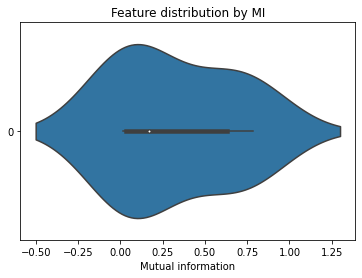

In [41]:
mi_scores = mutual_info_regression(features_train, target_train, random_state=RANDOM_STATE)
sns.violinplot(data=mi_scores, orient='h').set(title='Feature distribution by MI', xlabel='Mutual information');

In [42]:
mic_data = pd.DataFrame()
mic_data['feature'] = features_train.columns
mic_data['MIC'] = mi_scores
  
mic_data.sort_values(by='MIC', ascending=False)

,feature,MIC
3,indicator,0.782119
4,store_kagglerama,0.631131
2,day,0.168074
1,dayofweek,0.031586
0,ny,0.015767


In [43]:
recommended_columns = list(set(mic_data[mic_data['MIC'] > 0.02]['feature']))

In [44]:
recommended_columns

['store_kagglerama', 'dayofweek', 'indicator', 'day']

### VIF and correlations

In [45]:
vif_data = pd.DataFrame()
vif_data['feature'] = features_train[recommended_columns].columns
vif_data['VIF'] = [variance_inflation_factor(features_train[recommended_columns].values, i) for i in range(len(features_train[recommended_columns].columns))]
  
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
2,indicator,6.976438
0,store_kagglerama,4.465172
3,day,3.591850
1,dayofweek,2.989545


In [46]:
recommended_columns

['store_kagglerama', 'dayofweek', 'indicator', 'day']

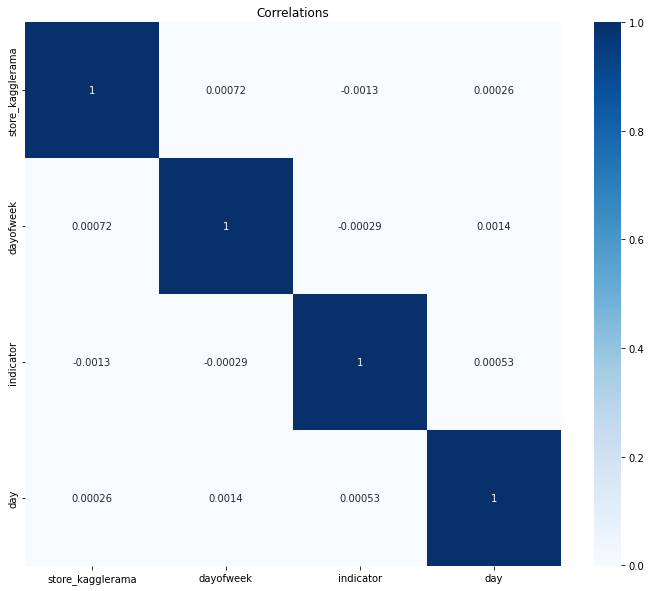

In [47]:
plt.figure(figsize=(12,10))
sns.heatmap(features_train[recommended_columns].corr(), annot=True, cmap='Blues').set(title='Correlations');

Cannot complain. Indicator VIF is a bit high, but guess that's inevitable.

## Training our models

### Implementing SMAPE metric

In [48]:
def smape(target, predictions):
    result = np.mean(np.nan_to_num(abs(target - predictions) / ((abs(target)+abs(predictions))/2), posinf=0)) * 100.
    return result

In [49]:
smape_score = make_scorer(smape, greater_is_better=False)

### Hyperparameter tuning

In [50]:
scaler_list = [MinMaxScaler(),
               StandardScaler(),
               RobustScaler(),
               PowerTransformer(),
               QuantileTransformer(random_state=RANDOM_STATE),
               QuantileTransformer(random_state=RANDOM_STATE, output_distribution='normal')]

In [51]:
def optimize(model, params, X, y):
    name = f'{type(model).__name__}'
    print(f'Optimizing {name}...')
    pipe = Pipeline([('scaler', StandardScaler()), ('regressor', model)]) 
    gcv = BayesSearchCV(pipe, search_spaces=params, cv=5, scoring='neg_mean_squared_error', random_state=RANDOM_STATE, n_jobs=-1)
    gcv.fit(X, y)
    print(f'Best params: {dict(gcv.best_params_)}')
    print(f'MSE: {-(gcv.best_score_):.2f}')
    return gcv.best_estimator_

In [52]:
%%time
linear_params = {
                    'scaler': scaler_list,
                    'regressor__fit_intercept':[True, False],
                }
best_linear = optimize(LinearRegression(n_jobs=-1), linear_params, features_train[recommended_columns], target_train)

Optimizing LinearRegression...
Best params: {'regressor__fit_intercept': True, 'scaler': RobustScaler()}
MSE: 2272.63
CPU times: user 2min 52s, sys: 2min 1s, total: 4min 53s
Wall time: 1min 46s


In [53]:
%%time
forest_params = {
                    'scaler': scaler_list,
                    'regressor__max_depth' : list(range(5, 30)),
                    'regressor__n_estimators' : [100, 200, 500, 1000, 2000],
                    'regressor__max_features' : ['sqrt', 'log2'],
                }
best_forest = optimize(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1), forest_params, features_train[recommended_columns], target_train)

Optimizing RandomForestRegressor...
Best params: {'regressor__max_depth': 26, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 500, 'scaler': PowerTransformer()}
MSE: 328.92
CPU times: user 3min 59s, sys: 2min 7s, total: 6min 6s
Wall time: 51min 33s


In [54]:
%%time
best_et = optimize(ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1), forest_params, features_train[recommended_columns], target_train)

Optimizing ExtraTreesRegressor...
Best params: {'regressor__max_depth': 22, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 1000, 'scaler': MinMaxScaler()}
MSE: 331.07
CPU times: user 4min 3s, sys: 2min 3s, total: 6min 7s
Wall time: 33min 9s


In [55]:
%%time
xgb_params = {
                    'scaler': scaler_list,
                    'regressor__max_depth' : list(range(1,7)),
                    'regressor__n_estimators' : [1000, 2000, 3000],
                    'regressor__min_child_weight' : list(range(6)),
                }
best_xgb = optimize(XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1), xgb_params, features_train[recommended_columns], target_train)

Optimizing XGBRegressor...
Best params: {'regressor__max_depth': 5, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 2000, 'scaler': RobustScaler()}
MSE: 315.05
CPU times: user 5min 59s, sys: 1min 57s, total: 7min 56s
Wall time: 1h 38min 12s


### Evaluation

In [56]:
def visualize_test(model, y_test):
    try:
        name = type(model[1]).__name__
    except:
        name = type(model).__name__
    prediction =  np.round(model.predict(features_test[recommended_columns]))
    mape = mean_absolute_percentage_error(y_test, prediction)
    smap = smape(y_test, prediction.reshape(-1))
    r2 = r2_score(y_test, prediction)
    print(f'Model: {name}, SMAPE: {smap:.1f}, MAPD: {mape:.1f}, R2: {r2:.1f}')

In [57]:
models = [best_linear, best_forest, best_et, best_xgb]
model_legend = [type(model[1]).__name__ for model in models]

In [58]:
for model in models:
    visualize_test(model, target_test)

Model: LinearRegression, SMAPE: 20.1, MAPD: 0.2, R2: 0.9
Model: RandomForestRegressor, SMAPE: 5.1, MAPD: 0.1, R2: 1.0
Model: ExtraTreesRegressor, SMAPE: 5.1, MAPD: 0.1, R2: 1.0
Model: XGBRegressor, SMAPE: 5.0, MAPD: 0.1, R2: 1.0


### Feature Importances

In [59]:
def importance_summary(model_list, X_test, y_test, feature_names):
    importances = pd.DataFrame()
    
    for model in model_list:
        importance = permutation_importance(model,
                                            X_test,
                                            y_test,
                                            random_state=RANDOM_STATE).importances_mean
        importances = importances.append (pd.Series(importance, index=feature_names),
                                          ignore_index=True)
    
    importances = importances.div(importances.sum (axis=1), axis=0)
    importances.T.plot(kind='bar', figsize=(10,5), width=0.7).set(title="Feature importance",
                                                                  ylabel="Importance (normalized)");
    plt.legend(model_legend);

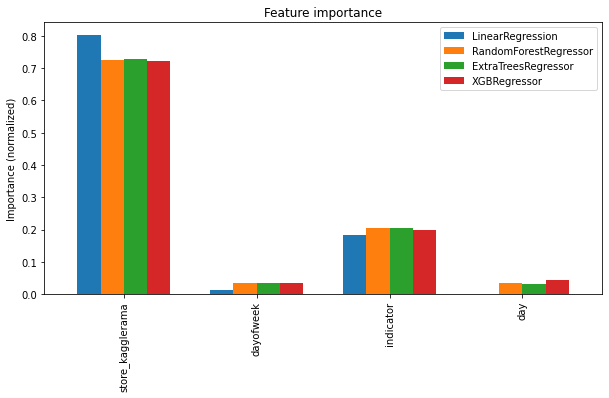

In [60]:
importance_summary(models, features_test[recommended_columns], target_test, list(features_train[recommended_columns].columns))

### Ensembling

We'll train a voting (evaluating as the most suitable for this task), and a stacking ensemble.

In [61]:
voters = [('forest', best_forest), ('xgb',best_xgb)]

In [62]:
vote = VotingRegressor(estimators=voters, n_jobs=-1)

In [63]:
stack = StackingRegressor(estimators=voters, final_estimator=LinearRegression(), n_jobs=-1)

In [64]:
vote.fit(features_train[recommended_columns], target_train)

VotingRegressor(estimators=[('forest',
                             Pipeline(steps=[('scaler', PowerTransformer()),
                                             ('regressor',
                                              RandomForestRegressor(max_depth=26,
                                                                    max_features='sqrt',
                                                                    n_estimators=500,
                                                                    n_jobs=-1,
                                                                    random_state=177013))])),
                            ('xgb',
                             Pipeline(steps=[('scaler', RobustScaler()),
                                             ('regressor',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           callbacks=None,


In [65]:
stack.fit(features_train[recommended_columns], target_train)

StackingRegressor(estimators=[('forest',
                               Pipeline(steps=[('scaler', PowerTransformer()),
                                               ('regressor',
                                                RandomForestRegressor(max_depth=26,
                                                                      max_features='sqrt',
                                                                      n_estimators=500,
                                                                      n_jobs=-1,
                                                                      random_state=177013))])),
                              ('xgb',
                               Pipeline(steps=[('scaler', RobustScaler()),
                                               ('regressor',
                                                XGBRegressor(base_score=0.5,
                                                             booster='gbtree',
                                                 

In [66]:
for model in [vote, stack]:
    visualize_test(model, target_test)

Model: VotingRegressor, SMAPE: 5.0, MAPD: 0.0, R2: 1.0
Model: StackingRegressor, SMAPE: 5.0, MAPD: 0.1, R2: 1.0


## Test set prediction

In [67]:
df2 = pd.read_csv('/kaggle/input/tabular-playground-series-sep-2022/test.csv', index_col=['row_id'], parse_dates=['date'])

In [68]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17520 entries, 70128 to 87647
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     17520 non-null  datetime64[ns]
 1   country  17520 non-null  object        
 2   store    17520 non-null  object        
 3   product  17520 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 684.4+ KB


In [69]:
df2 = (
        df2.pipe(one_hot_encoding, encoded_columns)
        .pipe(create_date_features)
        .pipe(drop_unused_columns, unused_columns)
        .pipe(name_cleanup)
        .pipe(bin_to_ratio, ['store_kagglerama'], 0.34679)
    )

In [70]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17520 entries, 70128 to 87647
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   store_kagglerama  17520 non-null  float64
 1   ny                17520 non-null  int64  
 2   dayofweek         17520 non-null  int64  
 3   day               17520 non-null  int64  
 4   indicator         17520 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 821.2 KB


In [71]:
df2.isna().mean()

store_kagglerama    0.0
ny                  0.0
dayofweek           0.0
day                 0.0
indicator           0.0
dtype: float64

In [72]:
df2

,store_kagglerama,ny,dayofweek,day,indicator
row_id,,,,,
70128,1.00000,1,4,1,0.280869
70129,1.00000,1,4,1,0.228091
70130,1.00000,1,4,1,0.187821
70131,1.00000,1,4,1,0.303218
70132,0.34679,1,4,1,0.280869
...,...,...,...,...,...
87643,1.00000,1,4,365,0.305890
87644,0.34679,1,4,365,0.268202
87645,0.34679,1,4,365,0.236426


In [73]:
prediction = vote.predict(df2[recommended_columns])

In [74]:
test_results = pd.DataFrame(data = {'row_id': df2.index, 'num_sold': prediction}).set_index('row_id').apply(round)

In [75]:
test_results

,num_sold
row_id,
70128,494.0
70129,411.0
70130,330.0
70131,524.0
70132,169.0
...,...
87643,738.0
87644,251.0
87645,205.0


In [76]:
test_results.to_csv('submission.csv')